In [1]:
import sys
sys.path.append('/mnt/Work/LaGonaveFM/') # or use path 
sys.path.append('/home/aesgeorges/LaGonaveFM/')
from codebase.figures import *
from codebase.tools import *

import cmocean
import numpy as np
import netCDF4 as netcdf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
from kalpana.plotting import plot_nc
from kalpana.export import fort14togdf
from kalpana.ADCIRC_tools import extract_ts_from_nc
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib as mpl
import geopandas as gpd

import pandas as pd
import xarray as xr
import rasterio as rio
import rioxarray as rxr

import fiona
from shapely.geometry import shape

import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})


from rasterio.features import dataset_features
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
#from cmcrameri import cm as cmc

In [2]:
plt.rcParams.update({
    'font.size': 18,
    "text.usetex": True,
    })

#  Analysis of Mangrove Retreat + Sea Level Rise ADCIRC Simulations

Featuring modded Hurricane Matthew Track v1

## Data Imports

In [20]:
scenario_r0 = 'Gonave_SLR_retreats/r0' # No Retreat (Close to 2010 cover)
scenario_r1 = 'Gonave_SLR_retreats/r1' # Light Retreat (Close to 2020 cover)
scenario_r2 = 'Gonave_SLR_retreats/r2'
scenario_r3 = 'Gonave_SLR_retreats/r3'
scenario_r4 = 'Gonave_SLR_retreats/r4'

root = f'../sims/'

cities_extents = '../datasets/other/cities.shp'

In [4]:
# Read the shapefile using fiona
with fiona.open(cities_extents, 'r') as src:
    cities = pd.DataFrame([feature['properties'] for feature in src])
    cities['geometry'] = [shape(feature['geometry']) for feature in src]

cities_gdf = gpd.GeoDataFrame(cities, geometry='geometry')
cities_gdf

Name  id                                           geometry
0  Desdunes   0  POLYGON ((-72.65229 19.30147, -72.65162 19.301...
1  L'Estere   1  POLYGON ((-72.60486 19.31420, -72.60363 19.314...
2  Gonaives   3  POLYGON ((-72.69655 19.45433, -72.69628 19.455...

In [23]:
horizons = [2030, 2050, 2070, 2100]
scenarios = ['SSP1','SSP2','SSP3','SSP5']   
retreats = ['r0', 'r1', 'r2', 'r3', 'r4']

covers_gdf = gpd.GeoDataFrame(index=retreats, columns=['geometry'])

cover_path_tails = ['_retreat_light.shp', '_retreat_light2.shp', '_retreat_medium.shp', '_retreat_heavy.shp']
cover_root = '../datasets/mangrove_covers/refined/mangrove_polygon'

base_cover_path = '../datasets/mangrove_covers/refined/base/mangrove_polygon_refined.shp'
with fiona.open(base_cover_path, 'r') as src:
        base_cover = pd.DataFrame([feature['properties'] for feature in src])
        base_cover['geometry'] = [shape(feature['geometry']) for feature in src]
covers_gdf.iloc[0] = base_cover.iloc[0]['geometry']

for i, retreat in enumerate(cover_path_tails):
    path = f'{cover_root}{retreat}'
    with fiona.open(path, 'r') as src:
        cover = pd.DataFrame([feature['properties'] for feature in src])
        cover['geometry'] = [shape(feature['geometry']) for feature in src]
    cover_gdf = gpd.GeoDataFrame(cover, geometry='geometry')
    covers_gdf.iloc[i+1] = cover['geometry'].iloc[0]  # Assuming each retreat has one geometry

cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover_r1 = gpd.GeoSeries([covers_gdf.loc[f'r1']['geometry']])
cover_r2 = gpd.GeoSeries([covers_gdf.loc[f'r2']['geometry']])
cover_r3 = gpd.GeoSeries([covers_gdf.loc[f'r3']['geometry']])

In [24]:
r0_s0_path = f'{root}{scenario_r0}/S0/hotstart/maxele.63.nc'
r0_s0_data = netcdf.Dataset(r0_s0_path, 'r') # Baseline Sim

r1_s0_path = f'{root}{scenario_r1}/S0/hotstart/maxele.63.nc'
r1_s0_data = netcdf.Dataset(r1_s0_path, 'r') # Mangrove S0 Light Retreat Sim

r2_s0_path = f'{root}{scenario_r2}/S0/hotstart/maxele.63.nc'
r2_s0_data = netcdf.Dataset(r2_s0_path, 'r') # Mangrove S0 Medium Retreat Sim 1

r3_s0_path = f'{root}{scenario_r3}/S0/hotstart/maxele.63.nc'
r3_s0_data = netcdf.Dataset(r3_s0_path, 'r') # Mangrove S0 Medium Retreat Sim 2

r4_s0_path = f'{root}{scenario_r4}/S0/hotstart/maxele.63.nc'
r4_s0_data = netcdf.Dataset(r4_s0_path, 'r') # Mangrove S0 High Retreat Sim 2

In [35]:
cover_areas = pd.DataFrame(index=['r0', 'r1', 'r2', 'r3', 'r4'], columns=['area', 'reduc'])
cover_areas['area'] = [59.357870314, 57.739306451, 49.847995628, 34.370843333, 10.052895761]
cover_areas['reduc'] = cover_areas['area'].pct_change() * 100
cover_areas['base_reduc'] = 100*(cover_areas['area'].divide(cover_areas['area'][0]) - 1)
cover_areas

#df.divide(df["A"], axis="index") - 1

area      reduc  base_reduc
r0  59.357870        NaN    0.000000
r1  57.739306  -2.726789   -2.726789
r2  49.847996 -13.667138  -16.021253
r3  34.370843 -31.048695  -42.095558
r4  10.052896 -70.751676  -83.063921

## Functions

In [36]:
def scenario_data(scenario, year):
    r0_path = f'{root}{scenario_r0}/{scenario}_{year}/hotstart/maxele.63.nc'
    r0_data = netcdf.Dataset(r0_path, 'r') # Baseline Sim

    r1_path = f'{root}{scenario_r1}/{scenario}_{year}/hotstart/maxele.63.nc'
    r1_data = netcdf.Dataset(r1_path, 'r') # Mangrove S0 Light Retreat Sim

    r2_path = f'{root}{scenario_r2}/{scenario}_{year}/hotstart/maxele.63.nc'
    r2_data = netcdf.Dataset(r2_path, 'r') # Mangrove S0 Medium Retreat Sim

    r3_path = f'{root}{scenario_r3}/{scenario}_{year}/hotstart/maxele.63.nc'
    r3_data= netcdf.Dataset(r3_path, 'r') # Mangrove S0 Medium 2 Retreat Sim
    
    r4_path = f'{root}{scenario_r4}/{scenario}_{year}/hotstart/maxele.63.nc'
    r4_data= netcdf.Dataset(r4_path, 'r') # Mangrove S0 Heavy Retreat Sim

    return r0_data, r1_data, r2_data, r3_data, r4_data

In [9]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib import cm

def create_zero_centered_colormap(data_min, data_max, base_cmap='RdBu_r', n_colors=256):
    """
    Create a colormap where zero maps to the middle color, regardless of data asymmetry
    """
    # Calculate where zero should be positioned (0 to 1 scale)
    data_range = data_max - data_min
    zero_position = (0 - data_min) / data_range
    
    print(f"Zero will be positioned at {zero_position:.3f} along the colormap")
    
    # Get the base colormap
    base_cmap = cm.get_cmap(base_cmap)
    
    # Create color segments
    if zero_position <= 0:
        # All positive values - use only the "positive" half of RdBu_r (blues)
        colors = base_cmap(np.linspace(0.5, 0, n_colors))
    elif zero_position >= 1:
        # All negative values - use only the "negative" half of RdBu_r (reds)  
        colors = base_cmap(np.linspace(1, 0.5, n_colors))
    else:
        # Mixed data - create asymmetric colormap
        n_negative = int(n_colors * zero_position)
        n_positive = n_colors - n_negative
        
        # Colors for negative values (red end)
        negative_colors = base_cmap(np.linspace(1, 0.5, n_negative))
        # Colors for positive values (blue end)  
        positive_colors = base_cmap(np.linspace(0.5, 0, n_positive))
        
        colors = np.vstack([negative_colors, positive_colors])
    
    return LinearSegmentedColormap.from_list('zero_centered', colors)

In [10]:
def plot_flood_extent(run, ax, color):
    tri = mpl.tri.Triangulation(run['x'][:].data, run['y'][:].data, run['element'][:,:] - 1)
    aux = run.variables['zeta_max'][:].data

    ax.tricontour(tri, aux, levels=0, colors=color, extend='neither')
    ax.set_xlim(-72.85, -72.6)
    ax.set_ylim(19.25, 19.5)

In [11]:
def compute_retreat_diff(ds_0, ds_1):
    """
    Compute the retreat effect of mangroves by comparing zeta_max between mangrove and bare scenarios.
    Returns a dictionary with spatial data and retreat results.
    """
    zeta_mangrove = ds_0.variables['zeta_max'][:]
    zeta_bare = ds_1.variables['zeta_max'][:]
    fill_value = ds_1['zeta_max']._FillValue

    # Convert fill values to zero for calculation
    zeta_m_calc = np.ma.filled(zeta_mangrove, 0)
    zeta_b_calc = np.ma.filled(zeta_bare, 0)
    
    # Calculate protection
    protection = zeta_b_calc - zeta_m_calc
    
    # Restore fill values where both original datasets had fill values
    both_masked = np.ma.getmaskarray(zeta_mangrove) & np.ma.getmaskarray(zeta_bare)
    
    # Set fill value where both are masked, then convert to masked array
    protection[both_masked] = fill_value
    protection = np.ma.masked_where(both_masked, protection, copy=False)
    protection.set_fill_value(fill_value)

    results = {}
    results['x'] = ds_0.variables['x'][:]
    results['y'] = ds_0.variables['y'][:]
    results['element'] = ds_0.variables['element'][:]
    results['depth'] = ds_0.variables['depth'][:]
    results['zeta_mangrove'] = zeta_mangrove
    results['zeta_bare'] = zeta_bare
    results['protection'] = protection
    results['attrs'] = {attr: getattr(ds_0, attr) for attr in ds_0.ncattrs()}
    return results

In [12]:
def plot_zeta_diff(diff_zeta, extent=[-72.85, -72.6, 19.25, 19.5]):
        fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

        min_val = round(diff_zeta['protection'].min(), 1)
        max_val = round(diff_zeta['protection'].max(), 1)
        
        zeroed_cmap = create_zero_centered_colormap(min_val, max_val, base_cmap='seismic_r', n_colors=48)

        m = plot_nc(
                diff_zeta, 'protection',
                levels=np.arange(min_val, max_val, 0.25),
                background_map=False, cbar=True,
                cb_label='Max water level difference [mMSL]',
                cmap=zeroed_cmap,
                extend='neither',
                fig=fig, ax=ax
        )
        cities_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linestyle='--', zorder=10)
        cities = ['Desdunes', "L'Estere", 'Gonaives']
        for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
                ax.text(x, y, str(label), fontsize=10, color='black', ha='center', va='center', zorder=11)

        ax.set_extent(extent, crs=ccrs.PlateCarree())
        #ax.set_title(f'Mangrove Protection - {scenario}_{year}')
        gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10)
        gl.top_labels = False
        gl.right_labels = False
        coast = cf.GSHHSFeature(scale='full', levels=[1,2,3,4], alpha=1.0, edgecolor='black')
        #ax.add_feature(cf.LAKES)
        #ax.add_feature(coast)
        return fig, ax

In [13]:
def plot_wse_comparisons(data_0, data_1, cover_base, cover):
    results = compute_retreat_diff(data_0, data_1)
    fig, ax = plot_zeta_diff(results)

    plot_flood_extent(data_0, ax, '#30c67c')
    plot_flood_extent(data_1, ax, '#FF930F')

    retreats = ['r0']
    covers_gdf = gpd.GeoDataFrame(index=retreats, columns=['geometry'])

    cover_base.plot(ax=ax, edgecolor='black', facecolor='none', linestyle='--', zorder=10, linewidth=0.8)
    cover.plot(ax=ax, edgecolor='limegreen', hatch='++', facecolor='none', alpha=0.5, linestyle='-', zorder=10, linewidth=0.8)
    cover.plot(ax=ax, edgecolor='limegreen', facecolor='none', linestyle='-', zorder=10, linewidth=0.8)

    cover_loss = gpd.overlay(gpd.GeoDataFrame(geometry=cover), gpd.GeoDataFrame(geometry=cover_base), how='symmetric_difference')
    cover_loss.plot(ax=ax, edgecolor='none', hatch='///', facecolor='red', alpha=0., zorder=10)

    legend_patches = [
        mpatches.Patch(color='limegreen', edgecolor='limegreen', alpha=0.5, hatch=r'+', label='Mangrove Cover'),
        mpatches.Patch(facecolor='lightgrey', alpha=0.1, hatch=r'//////', label='Mangrove Cover Loss'),
        Line2D([0], [0], color='red', lw=2, label='Additional Flooding Area'),
    ]

    return results, fig, ax
    #fig.savefig(f"/mnt/Work/mangrove-thesis/figures/attenuation/mangrove_protection_baseline.png", dpi=600, bbox_inches='tight')
    #fig.savefig(f"exports/figures/mangrove_protection_{scenario}_{year}.png", dpi=600, bbox_inches='tight')

In [14]:
def plot_flood_extent_comparisons(r0_data, r1_data, r2_data, r3_data, title_scene):
    fig, ax = plt.subplots(figsize = (10,6), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)

    custom_gradient = ["#0004FF", "#30c67c", "#FF930F", "#FF0000"]

    plot_flood_extent(r0_data, ax, custom_gradient[0])
    plot_flood_extent(r1_data, ax, custom_gradient[1])
    plot_flood_extent(r2_data, ax, custom_gradient[2])
    plot_flood_extent(r3_data, ax, custom_gradient[3])

    ax.legend(handles=[mpl.lines.Line2D([], [], color=custom_gradient[0], label=f'R0 - Baseline'),
                    mpl.lines.Line2D([], [], color=custom_gradient[1], label=f'R1 - Light Retreat'),
                    mpl.lines.Line2D([], [], color=custom_gradient[2], label=f'R2 - Medium Retreat'),     
                    mpl.lines.Line2D([], [], color=custom_gradient[3], label=f'R3 - Heavy Retreat')], 
                    loc='upper left',
                    fontsize=12,)

    cities_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linestyle='--', zorder=10)
    cities = ['Desdunes', "L'Estere", 'Gonaives']
    for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
            ax.text(x, y, str(label), fontsize=10, color='black', ha='center', va='center', zorder=11)

    ax.set_xlim(-72.85, -72.6)
    ax.set_ylim(19.25, 19.5)

    gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10) 
    gl.top_labels = False
    gl.right_labels = False

    coast = cf.GSHHSFeature(scale='full', levels=[1,2,3,4], alpha=1.0, edgecolor='black')
    ax.add_feature(cf.LAKES)
    ax.add_feature(coast)

    ax.set_title(f'Inundation Extents for Different Mangrove Retreats - {title_scene}', fontsize=12)

    plt.rcParams.update({
    'font.size': 18,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    "text.usetex": True,
    })

    return fig, ax

In [15]:
import math

def calculate_pixel_area(lat, pixel_width_deg, pixel_height_deg):
    """Calculate area of a WGS84 pixel in square meters given its latitude and dimensions in degrees"""
    # WGS84 ellipsoid parameters
    a = 6378137.0  # Semi-major axis (equatorial radius) in meters
    b = 6356752.314245  # Semi-minor axis (polar radius) in meters
    e_sq = 1 - (b*b)/(a*a)  # Eccentricity squared
    
    # Calculate meters per degree
    lon_meters_per_deg = (math.pi/180) * a * math.cos(math.radians(lat)) / math.sqrt(1 - e_sq * math.pow(math.sin(math.radians(lat)), 2))
    lat_meters_per_deg = (math.pi/180) * a * (1 - e_sq) / math.pow(1 - e_sq * math.pow(math.sin(math.radians(lat)), 2), 1.5)
    
    # Calculate area
    return pixel_width_deg * lon_meters_per_deg * pixel_height_deg * lat_meters_per_deg

def calculate_flood_area(raster_path):
    # Open the raster file
    with rio.open(raster_path) as src:
        # Get the transform and dimensions
        transform = src.transform
        height = src.height
        width = src.width
        
        # Extract the pixel width and height in degrees
        pixel_width_deg = abs(transform[0])
        pixel_height_deg = abs(transform[4])
        
        # Read the raster data
        data = src.read(1).astype(float)  # Assuming single band raster and we're working with float type that can handle NaN
        data[data == -99999.0] = np.nan
        
        # Create a mask of valid (non-NaN) pixels
        valid_mask = ~np.isnan(data)
        valid_count = np.sum(valid_mask)
        
        # Get bounds
        bounds = src.bounds
        
        # Calculate total area of non-NaN pixels
        total_area = 0
        
        # Create an array of latitudes for each row
        # First, get the latitude of the top edge
        top_lat = bounds.top
        
        # For each row, calculate the latitude at the center of the pixels
        for row in range(height):
            # Calculate latitude at the center of this row of pixels
            # (subtract half a pixel to get to the center of the first pixel,
            # then subtract the appropriate number of pixels for the current row)
            row_lat = top_lat - (pixel_height_deg * (row + 0.5))
            
            # Calculate pixel area at this latitude
            pixel_area = calculate_pixel_area(row_lat, pixel_width_deg, pixel_height_deg)
            
            # Count valid pixels in this row and add their area to the total
            valid_pixels_in_row = np.sum(valid_mask[row, :])
            total_area += valid_pixels_in_row * pixel_area
        
        #print(f"Number of valid (non-NaN) pixels: {valid_count}")
        #print(f"Total area of valid pixels: {total_area:.2f} square meters ({total_area/1000000:.4f} square kilometers)")

        return total_area, valid_count

In [16]:
import matplotlib.patheffects as path_effects

def compute_diff(path_base_mangrove, path_base_nomangrove):
    base_mangrove = rxr.open_rasterio(path_base_mangrove)
    base_nomangrove = rxr.open_rasterio(path_base_nomangrove)

    base_mangrove = base_mangrove.where(base_mangrove != base_mangrove.attrs['_FillValue'], np.nan)
    base_nomangrove = base_nomangrove.where(base_nomangrove != base_nomangrove.attrs['_FillValue'], np.nan)

    diff = base_mangrove - base_nomangrove
    return diff


def plot_diff(diff, title):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)
    # Convert from NGVD29 to NAVD88 using an approximate offset (https://pubs.usgs.gov/sir/2010/5040/section.html)

    norm = colors.TwoSlopeNorm(vmin=diff.min(), vcenter=0, vmax=diff.max())

    n = diff.plot(ax=ax, cmap=cmocean.cm.balance, zorder=10, norm=norm, cbar_kwargs={'label': 'Difference in flood depth [m]'})
    cbar = n.colorbar
    cbar.set_label('Difference in flood depth [m]', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_yscale('linear')

    cities_gdf.plot(ax=ax, edgecolor='white', facecolor='gray', alpha=0.1, linestyle='--', zorder=10)
    cities_gdf.plot(ax=ax, edgecolor='white', facecolor='none', linestyle='--', zorder=10)
    cities = ['Desdunes', "L'Estere", 'Gonaives']
    for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
        t = ax.text(
            x, y, str(label),
            fontsize=10,
            color='white',
            ha='center',
            va='center',
            zorder=11,
        )
        t.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                       path_effects.Normal()])

    ax.set_xlim(-72.85, -72.58)
    ax.set_ylim(19.23, 19.5)

    print(diff.min(), diff.max())  

    ax.set_title(title, fontsize=16)

    #coastline = cf.GSHHSFeature(scale='full', levels=[1,2,3,4], alpha=1.0, edgecolor='black')
    #ax.add_feature(coastline, zorder=1)
    #ax.add_feature(cf.BORDERS, linestyle='--', alpha=0.5)

    gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10) 
    gl.top_labels = False
    gl.right_labels = False

    plt.rcParams.update({
    'font.size': 18,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    "text.usetex": True,
    })

    # Export the plot with a transparent background
    plt.savefig(f"exports/figures/{title}.png", dpi=600, bbox_inches='tight', transparent=True)
    
    return fig, ax

In [17]:
from rasterio.features import dataset_features
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

def plot_inter_extents(path1, path2, cover_base, cover, title_scene, title):
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)
    
    ras1 = rxr.open_rasterio(path1).squeeze()
    ras2 = rxr.open_rasterio(path2).squeeze()
    
    test1 = ras1.where(ras1 != ras1.attrs['_FillValue'], 0)
    test2 = ras2.where(ras2 != ras2.attrs['_FillValue'], 0)
    
    ras1 = ras1.where(ras1 != ras1.attrs['_FillValue'], np.nan)
    ras2 = ras2.where(ras2 != ras2.attrs['_FillValue'], np.nan)
 
    diff_test = (test2 - test1)
    diff_test = diff_test.where(diff_test != 0, np.nan)
    diff_mask = diff_test.where(~np.isnan(ras1))

    # Define 7 equal bins
    n_bins = 15
    bounds = np.linspace(-2.5, 2.5, n_bins + 1)

    # Create discrete colormap
    cmap = plt.cm.coolwarm  # or any colormap you prefer
    norm = colors.BoundaryNorm(bounds, cmap.N)

    #cmap = plt.get_cmap('PuOr', np.max(diff_test) - np.min(diff_test) + 1)
    #norm = colors.TwoSlopeNorm(vmin=np.nanmin(diff_test), vcenter=0, vmax=np.nanmax(diff_test))
    m = diff_test.plot(ax=ax, cmap=cmap, zorder=5, norm=norm, cbar_kwargs={'label': 'Difference in flood depth [m]'})
    cbar = m.colorbar

    with rio.open(path1) as src:
        outline = gpd.GeoDataFrame.from_features(dataset_features(src, bidx=1, as_mask=True, geographic=False, band=False))
    with rio.open(path2) as src:
        outline2 = gpd.GeoDataFrame.from_features(dataset_features(src, bidx=1, as_mask=True, geographic=False, band=False))

    # Mask outline2 with outline: keep only the parts of outline2 that intersect outline
    extra_flooding = gpd.overlay(outline, outline2, how='symmetric_difference')
    extra_flooding.plot(ax=ax, edgecolor='red', facecolor='none', zorder=5, linewidth=0.8)

    cities_gdf.plot(ax=ax, edgecolor='white', facecolor='gray', alpha=0.1, linestyle='--', zorder=10)
    cities_gdf.plot(ax=ax, edgecolor='white', facecolor='none', linestyle='--', zorder=10)
    cities = ['Desdunes', "L'Estere", 'Gonaives']

    cover_base.plot(ax=ax, edgecolor='black', facecolor='none', linestyle='--', zorder=10, linewidth=0.8)
    cover.plot(ax=ax, edgecolor='limegreen', hatch='++', facecolor='none', alpha=0.5, linestyle='-', zorder=10, linewidth=0.8)
    cover.plot(ax=ax, edgecolor='limegreen', facecolor='none', linestyle='-', zorder=10, linewidth=0.8)

    cover_loss = gpd.overlay(gpd.GeoDataFrame(geometry=cover), gpd.GeoDataFrame(geometry=cover_base), how='symmetric_difference')
    cover_loss.plot(ax=ax, edgecolor='none', hatch='///', facecolor='red', alpha=0., zorder=10)

    legend_patches = [
        mpatches.Patch(color='limegreen', edgecolor='limegreen', alpha=0.5, hatch=r'+', label='Mangrove Cover'),
        mpatches.Patch(facecolor='lightgrey', alpha=0.1, hatch=r'//////', label='Mangrove Cover Loss'),
        Line2D([0], [0], color='red', lw=2, label='Additional Flooding Area'),
    ]
    

    for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
        t = ax.text(
            x, y, str(label),
            fontsize=14,
            color='white',
            ha='center',
            va='center',
            zorder=11,
        )
        t.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                       path_effects.Normal()])

    ax.set_xlim(-72.8, -72.58)
    ax.set_ylim(19.23, 19.5)

    gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10) 
    gl.top_labels = False
    gl.right_labels = False

    ax.set_title(title, fontsize=18,  fontweight='bold')
    ax.legend(handles=legend_patches, loc='upper left', fontsize=18)

    plt.rcParams.update({
    'font.size': 18,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    "text.usetex": True,
    })
    
    plt.savefig(f"exports/figures/{title}.png", dpi=800, bbox_inches='tight', transparent=True)
    return diff_test

## Raw ADCIRC WSE and Flood Extents

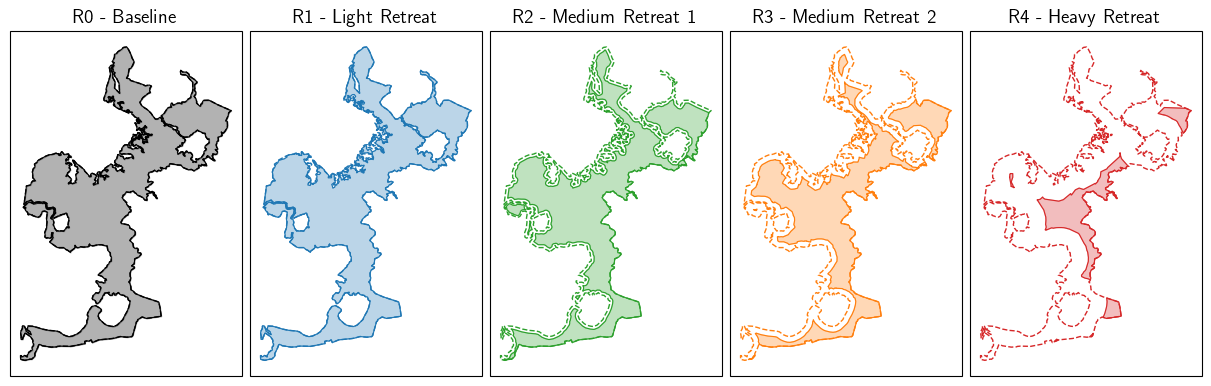

In [39]:
import rioxarray as rxr

fig, axes = plt.subplots(1, 5, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
axes = np.atleast_1d(axes)
    
colors = ['black', '#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']
retreat_labels = ['Baseline', 'Light Retreat', 'Medium Retreat 1', 'Medium Retreat 2', 'Heavy Retreat']
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])

for i in range(0, covers_gdf.shape[0]):
    cover = gpd.GeoSeries([covers_gdf.loc[f'r{i}']['geometry']])

    cover_base.plot(ax=axes[i], edgecolor=colors[i], facecolor='none', linestyle='--', zorder=10, linewidth=1.)
    cover.plot(ax=axes[i], edgecolor=colors[i], facecolor=colors[i], alpha=0.3, linestyle='-', zorder=10, linewidth=0.9)
    cover.plot(ax=axes[i], edgecolor=colors[i], facecolor='none', linestyle='-', zorder=10, linewidth=0.8)
    axes[i].set_title(f"R{i} - {retreat_labels[i]}", fontsize=14)

plt.savefig('/mnt/Work/mangrove-thesis/figures/mangrove_retreats.png', bbox_inches='tight', dpi=800)

### Cross Retreats Maps

In [40]:
scenario = 'SSP1'
year = '2100'

r0_data, r1_data, r2_data, r3_data, r4_data = scenario_data(scenario, year)

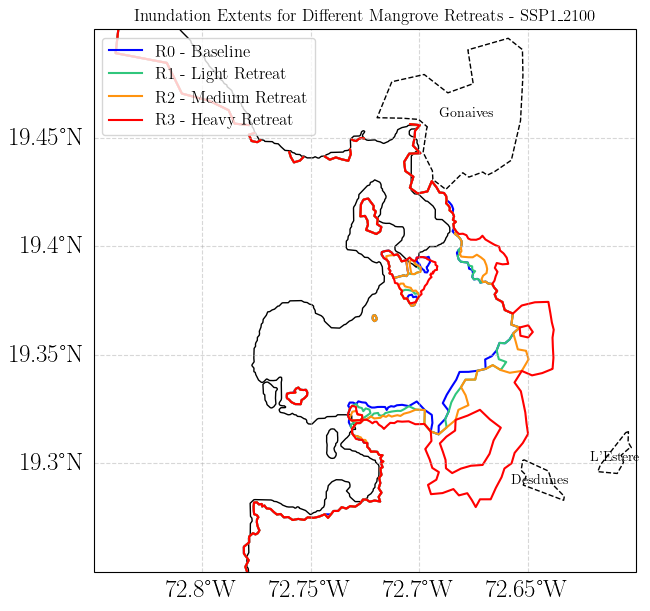

In [41]:
#plot_flood_extent_comparisons(r0_s0_data, r1_s0_data, r2_s0_data, r3_s0_data, 
        #                      title_scene = 'No SLR')
fig, ax = plot_flood_extent_comparisons(r1_data, r2_data, r3_data, r4_data,
                              title_scene = f'{scenario}_{year}')
fig.savefig(f"/mnt/Work/mangrove-thesis/figures/retreats/extents_{scenario}_{year}.png", dpi=600, bbox_inches='tight')

### Retreat Comparison Maps

In [310]:
scenario = 'SSP5'
year = '2100'

r0_data, r1_data, r2_data, r3_data = scenario_data(scenario, year)

Zero will be positioned at 0.415 along the colormap


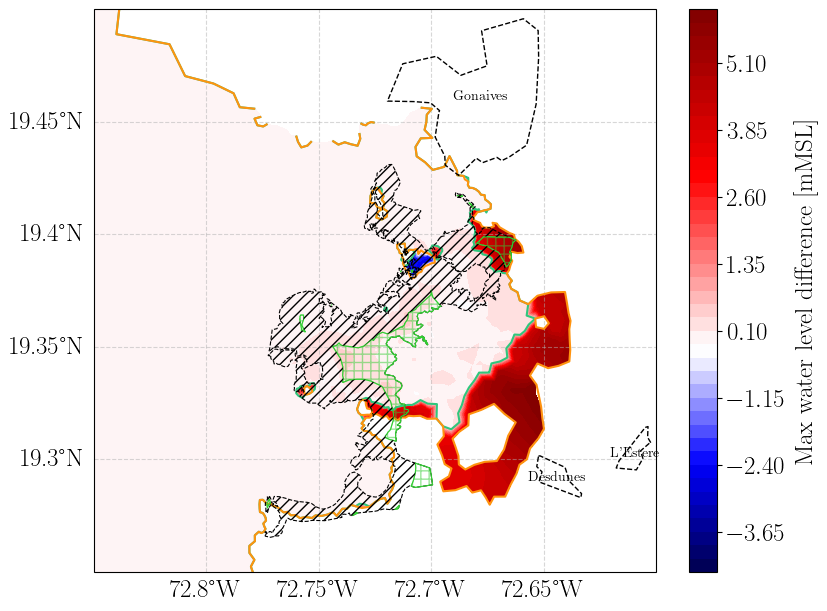

In [311]:
results, fig, ax = plot_wse_comparisons(r0_data, r3_data, cover_base, cover_r3)
fig.savefig(f"/mnt/Work/mangrove-thesis/figures/retreats/mangrove_r0_r3_{scenario}_{year}.png", dpi=600, bbox_inches='tight')

### Flooding Extent Projections

In [160]:
f"{root}{scenario_r0}/"

'../sims/Gonave_SLR_retreats/r0/'

In [ ]:
data_r0 = {}
data_r1 = {}
data_r2 = {}
data_r3 = {}
data_r4 = {}

def load_data(scenario, horizon, dict, root):

    for scenario in scenarios:
        dict[scenario] = {}
        for horizon in horizons:
            file_path = f'{root}{scenario}_{horizon}/hotstart/maxele.63.nc'
            dict[scenario][horizon] = netcdf.Dataset(file_path, 'r')
    return dict

data_r0 = load_data(scenarios, horizons, data_r0, f"{root}{scenario_r0}/")
data_r1 = load_data(scenarios, horizons, data_r1, f"{root}{scenario_r1}/")
data_r2 = load_data(scenarios, horizons, data_r2, f"{root}{scenario_r2}/")
data_r3 = load_data(scenarios, horizons, data_r3, f"{root}{scenario_r3}/")
data_r4 = load_data(scenarios, horizons, data_r4, f"{root}{scenario_r4}/")

### Functions

In [43]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D


def plot_flooded_area_with_slr(flooded_area_df, slr_df, cmap='Blues', col='blue'):
    """
    Plot flooded area projections with SLR projections as inset.

    Parameters:
        flooded_area_df (pd.DataFrame): Flooded area (km²) for each scenario and year.
        slr_df (pd.DataFrame): SLR projections (m) for each scenario and year.
        cmap (str): Colormap for flooded area lines.

    Returns:
        fig, ax, ax2: Matplotlib figure and axes.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = [cm.get_cmap(cmap)(i) for i in [0.35, 0.55, 0.75, 0.95]]
    bone_colors = [cm.get_cmap('bone_r')(i) for i in [0.35, 0.55, 0.75, 0.95]]
    styles = ['-', '--', '-.', ':']

    # Create ax2 as an inset in the bottom right corner
    ax2 = inset_axes(ax, width="30%", height="30%", loc='lower right', borderpad=2)
    ax2.tick_params(axis='both', labelsize=10)
    ax2.set_ylabel('SLR (m)', fontsize=10)

    years = flooded_area_df.index.astype(int)
    ax2.set_xticks(years)

    for idx, scenario in enumerate(flooded_area_df.columns):
        flooded_area_df[scenario].plot(ax=ax, color=colors[idx], style=['.'], alpha=1)
        flooded_area_df[scenario].plot(ax=ax, color=colors[idx], style=styles[idx], alpha=0.5)
        slr_df[scenario].plot(ax=ax2, color=bone_colors[idx], style=styles[idx], alpha=1, label=f'SLR {scenario}')

    # Convert index to numeric for regression
    areas_mean = flooded_area_df.mean(axis=1).astype(float)
    slope, intercept = np.polyfit(years, areas_mean, 1)
    trend = slope * years + intercept
    pos = slope * 2030 + intercept

    ax.plot(years, trend, '-', color=col)
    ax.text(2031, pos - 0.5, f'a = {slope:.2f} km²/year', color=col, fontsize=10)
    ax.set_xlabel('Year')
    ax.set_ylabel('Flooded Area (km²)')

    custom_lines = [
        Line2D([0], [0], color=col, linestyle='-', label='Trend'),
        Line2D([0], [0], color='gray', linestyle='-', label='SSP1', alpha=0.8),
        Line2D([0], [0], color='gray', linestyle='--', label='SSP2', alpha=0.8),
        Line2D([0], [0], color='gray', linestyle='-.', label='SSP3', alpha=0.8),
        Line2D([0], [0], color='gray', linestyle=':', label='SSP5', alpha=0.8),
    ]
    ax.legend(handles=custom_lines, loc='upper left', fontsize=10)
    ax.grid(axis='x', which='major', linestyle='--')
    ax.grid(axis='y', linestyle='--')
    ax.set_xticks(years)
    return fig, ax, ax2

In [59]:
def plot_flooded_area_projections(data, ax, scenario, retreat_id, cmap, col):
    colors = [cm.get_cmap(cmap)(i) for i in [0.35, 0.55, 0.75, 0.95]]
    styles = ['-', '--', '-.', ':']

    # Create ax2 as an inset in the bottom right corner
    years = data.index.astype(int)
    for idx, scenario in enumerate(data.columns):
        data[scenario].plot(ax=ax, color=colors[idx], style=['.'], alpha=1)
        data[scenario].plot(ax=ax, color=colors[idx], style=styles[idx], alpha=0.4)

    # Convert index to numeric for regression
    areas_mean = data.mean(axis=1).astype(float)
    slope, intercept = np.polyfit(years, areas_mean, 1)
    trend = slope * years + intercept
    pos = slope * 2030 + intercept

    ax.plot(years, trend, '-', color=col)
    ax.text(2030 + 1.2*retreat_id, pos + 1.6*retreat_id - 1.1, f'a = {slope:.2f} km²/year', 
        color=col, fontsize=12, weight='bold',
        path_effects=[path_effects.Stroke(linewidth=5, foreground='white'),
                 path_effects.Normal()])
    ax.set_xticks(years)
    return ax

def plot_retreats_flooded_area(data_r0, data_r1, data_r2, data_r3, scenario, years):
    """
    Plot flooded area projections for different mangrove retreats.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']
    cmaps = ['Blues', 'Greens', 'Oranges', 'Reds']  # Custom colors for each retreat
    for i, data in enumerate([data_r0, data_r1, data_r2, data_r3]):
        plot_flooded_area_projections(data, ax, scenario, i, cmap=cmaps[i], col=colors[i])

    ax.set_xlabel('Year')
    ax.set_ylabel('Flooded Area (km²)')

    custom_lines = [
        Line2D([0], [0], color=colors[0], linestyle='-', label='R1 - Light Retreat'),
        Line2D([0], [0], color=colors[1], linestyle='-', label='R2 - Medium Retreat 1'),
        Line2D([0], [0], color=colors[2], linestyle='-', label='R2 - Medium Retreat 2'),
        Line2D([0], [0], color=colors[3], linestyle='-', label='R3 - Heavy Retreat'),
        Line2D([0], [0], color='gray', linestyle='-', label='SSP1', alpha=0.8),
        Line2D([0], [0], color='gray', linestyle='--', label='SSP2', alpha=0.8),
        Line2D([0], [0], color='gray', linestyle='-.', label='SSP3', alpha=0.8),
        Line2D([0], [0], color='gray', linestyle=':', label='SSP5', alpha=0.8),
    ]
    ax.legend(handles=custom_lines, loc='upper left', fontsize=12)
    ax.grid(axis='x', which='major', linestyle='--')
    ax.grid(axis='y', linestyle='--')
    
    return fig, ax

def plot_retreats_flooded_area_vs(data_r1, data_r2, scenario, years):
    """
    Plot flooded area projections for different mangrove retreats.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    colors = ['#1f77b4', '#d62728']
    cmaps = ['Blues', 'Reds']  # Custom colors for each retreat
    for i, data in enumerate([data_r1, data_r2]):
        plot_flooded_area_projections(data, ax, scenario, i, cmap=cmaps[i], col=colors[i])

    ax.set_xlabel('Year')
    ax.set_ylabel('Flooded Area (km²)')

    custom_lines = [
        Line2D([0], [0], color=colors[0], linestyle='-', label='R0 - Baseline Retreat'),
        Line2D([0], [0], color=colors[1], linestyle='-', label='R1 - Light Retreat 1'),
        Line2D([0], [0], color='gray', linestyle='-', label='SSP1', alpha=0.8),
        Line2D([0], [0], color='gray', linestyle='--', label='SSP2', alpha=0.8),
        Line2D([0], [0], color='gray', linestyle='-.', label='SSP3', alpha=0.8),
        Line2D([0], [0], color='gray', linestyle=':', label='SSP5', alpha=0.8),
    ]
    ax.legend(handles=custom_lines, loc='upper left', fontsize=12)
    ax.grid(axis='x', which='major', linestyle='--')
    ax.grid(axis='y', linestyle='--')
    
    return fig, ax

In [45]:
from shapely.geometry import Polygon

def calculate_flooded_area_geopandas(x, y, elements, flooded_nodes):
    """
    Calculate flooded area using GeoPandas with equal-area projection
    """
    flooded_polygons = []
    
    for elem in elements:
        v1, v2, v3 = elem - 1  # Adjust for ADCIRC's one-based indexing
        
        if flooded_nodes[v1] or flooded_nodes[v2] or flooded_nodes[v3]:
            triangle = Polygon([(x[v1], y[v1]), (x[v2], y[v2]), (x[v3], y[v3])])
            if triangle.is_valid:
                flooded_polygons.append(triangle)
    
    if len(flooded_polygons) == 0:
        return 0
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=flooded_polygons, crs='EPSG:4326')
    
    # Use Lambert Azimuthal Equal Area projection centered on Haiti for accurate area calculation
    haiti_center_lon = -72.5
    haiti_center_lat = 18.5
    equal_area_proj = f'+proj=laea +lat_0={haiti_center_lat} +lon_0={haiti_center_lon} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs'
    
    # Convert to equal area projection
    gdf_projected = gdf.to_crs(equal_area_proj)
    
    # Calculate total area in km²
    total_area_km2 = gdf_projected.geometry.area.sum() / 1e6
    
    return total_area_km2

In [46]:
def build_flooded_area_df(scenarios, horizons, data):
    flooded_area = pd.DataFrame(index=horizons, columns=scenarios)
    for scenario in scenarios:
        for year in horizons:
            run = data[scenario][year]
            
            x = run['x'][:]
            y = run['y'][:]
            elements = run['element'][:]
            depth = run['depth'][:]
            
            land_mask = depth < 0
            flood_mask = (run['zeta_max'][:] > 0) & land_mask

            flooded_area.loc[year, scenario] = calculate_flooded_area_geopandas(
                x, y, elements, flood_mask
            )

    return flooded_area

### Figures

In [47]:
flooded_area_r0 = build_flooded_area_df(scenarios, horizons, data_r0)
flooded_area_r1 = build_flooded_area_df(scenarios, horizons, data_r1)
flooded_area_r2 = build_flooded_area_df(scenarios, horizons, data_r2)
flooded_area_r3 = build_flooded_area_df(scenarios, horizons, data_r3)
flooded_area_r4 = build_flooded_area_df(scenarios, horizons, data_r4)

In [51]:
flooded_area_r2

SSP1       SSP2       SSP3       SSP5
2030  65.471649  65.471649  65.471649  65.471649
2050  71.850201  73.779864  73.779864  71.471959
2070  74.663064  78.027335  84.990156  87.378394
2100  88.530111  87.720635  92.642462   95.91524

In [53]:
SLR_projections = pd.DataFrame(index=horizons, columns=scenarios)
SLR_projections = pd.DataFrame({
    'SSP1': [0.12, 0.24, 0.36, 0.53],
    'SSP2': [0.12, 0.26, 0.41, 0.67],
    'SSP3': [0.12, 0.26, 0.43, 0.77],
    'SSP5': [0.12, 0.28, 0.47, 0.86]
}, index=horizons)

(<Figure size 800x800 with 2 Axes>,
 <AxesSubplot: xlabel='Year', ylabel='Flooded Area (km²)'>,
 <AxesHostAxes: ylabel='SLR (m)'>)

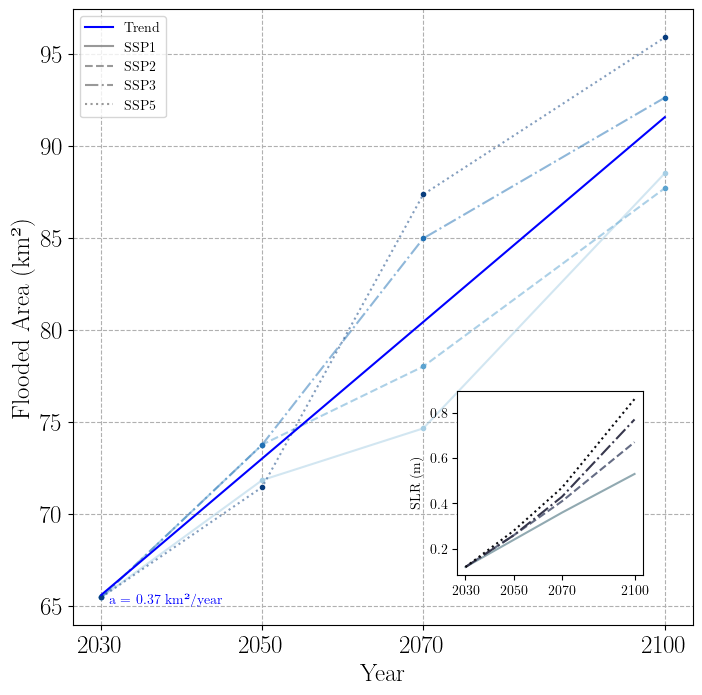

In [73]:
plot_flooded_area_with_slr(flooded_area_r2, SLR_projections, 'Blues', 'blue')

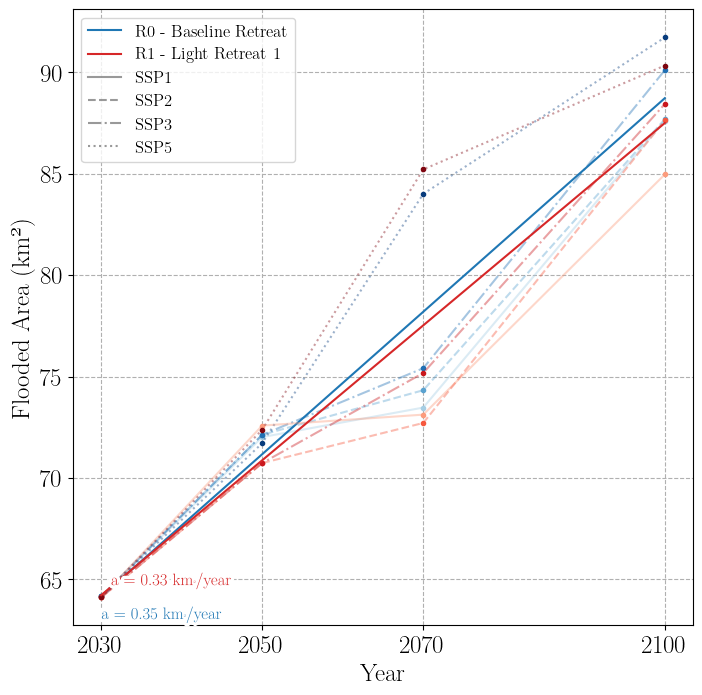

In [70]:
fig, ax = plot_retreats_flooded_area_vs(flooded_area_r0, flooded_area_r1, scenario, horizons)

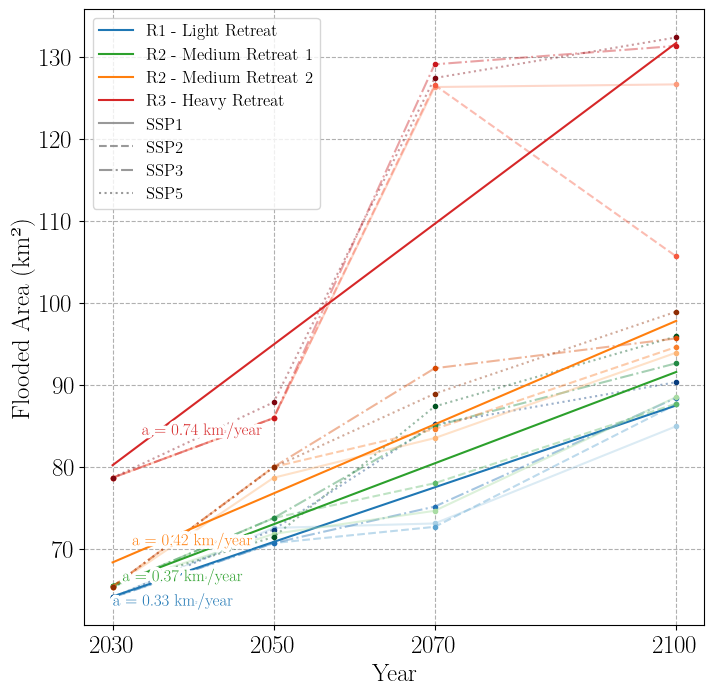

In [56]:
fig, ax = plot_retreats_flooded_area(flooded_area_r1, flooded_area_r2, flooded_area_r3, flooded_area_r4, scenario, horizons)

fig.savefig(f"/mnt/Work/mangrove-thesis/figures/retreats/retreats_flooding_projections.png", dpi=600, bbox_inches='tight')

## Interpolated Flooding Inundation Stats

In [ ]:
results_root = f'{root}Gonave_SLR_retreats/results/'

tail = '_flood_depths_exported.tif'

In [15]:
# s0 as first column
inundations = pd.DataFrame(index=horizons, columns=['s0'] + scenarios)

for scenario in scenarios:
    inun = []
    base = f'{results_root}{retreats[0]}/{retreats[0]}_s0{tail}'
    area, valid_n = calculate_flood_area(base)
    area = area / 1000000 # Convert to km²
    inundations['s0'] = area  # Append the area for the baseline scenario
    for year in horizons:
        path = f'{results_root}{retreats[0]}/{retreats[0]}_{scenario}_{year}{tail}'
        #print(path)
        area, valid_n = calculate_flood_area(path)
        area = area / 1000000 # Convert to km²
        inun.append(area)
    inundations[scenario] = inun

inundations

s0        ssp2        ssp5
2030  152.322831  154.404396  154.404396
2100  152.322831  176.328852  179.438109

In [16]:
pct_change_from_base = inundations.divide(inundations.iloc[0], axis="columns") - 1
pct_change_from_base.head()

s0      ssp2      ssp5
2030  0.0  0.000000  0.000000
2100  0.0  0.141994  0.162131

In [17]:
pct_change_yrly = inundations.pct_change(axis=0) * 100
pct_change_yrly

s0       ssp2       ssp5
2030  NaN        NaN        NaN
2100  0.0  14.199373  16.213083

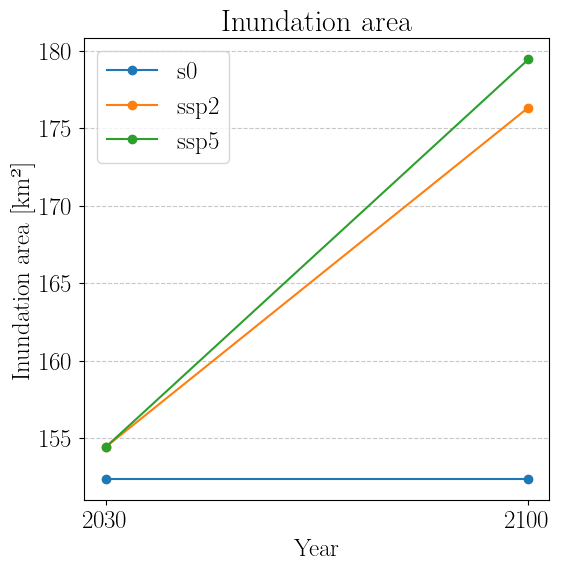

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
inundations.plot(ax=ax, marker='o')
ax.set_title('Inundation area')
ax.set_ylabel('Inundation area [km²]')
ax.set_xlabel('Year')
ax.set_xticks(range(len(horizons)))
ax.set_xticklabels(horizons)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

## Interpolated Flooding Inundation Maps

### Retreats vs SLR 
(Looking at the flooding extent over time for each retreat scenario)

In [19]:
covers_gdf = gpd.GeoDataFrame(index=retreats, columns=['geometry'])

cover_path_tails = ['_retreat_light.shp', '_retreat_medium.shp', '_retreat_heavy.shp']
cover_root = '../datasets/mangrove_covers/refined/mangrove_polygon'

base_cover_path = '../datasets/mangrove_covers/refined/base/mangrove_polygon_refined.shp'
with fiona.open(base_cover_path, 'r') as src:
        base_cover = pd.DataFrame([feature['properties'] for feature in src])
        base_cover['geometry'] = [shape(feature['geometry']) for feature in src]
covers_gdf.iloc[0] = base_cover.iloc[0]['geometry']

for i, retreat in enumerate(cover_path_tails):
    path = f'{cover_root}{retreat}'
    with fiona.open(path, 'r') as src:
        cover = pd.DataFrame([feature['properties'] for feature in src])
        cover['geometry'] = [shape(feature['geometry']) for feature in src]
    cover_gdf = gpd.GeoDataFrame(cover, geometry='geometry')
    covers_gdf.iloc[i+1] = cover['geometry'].iloc[0]  # Assuming each retreat has one geometry
covers_gdf

geometry
r0  POLYGON ((-72.69583 19.39900, -72.69393 19.399...
r1  MULTIPOLYGON (((-72.71323 19.38336, -72.71325 ...
r2  MULTIPOLYGON (((-72.76563 19.27981, -72.76313 ...
r3  MULTIPOLYGON (((-72.77298 19.27977, -72.77288 ...

In [20]:
cover = gpd.GeoSeries([covers_gdf.loc[f'r3']['geometry']])
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])

In [21]:
cover_loss = gpd.overlay(gpd.GeoDataFrame(geometry=cover), gpd.GeoDataFrame(geometry=cover_base), how='symmetric_difference')
# The area is in the units of the CRS of the GeoSeries, which for WGS84 (EPSG:4326) is degrees^2.
# For accurate area in square meters or kilometers, reproject to a projected CRS (e.g., UTM) before calling .area.
# This will be in degrees^2 if the geometry is in WGS84 (EPSG:4326)
covers_gdf.iloc[0]['geometry'].area

0.0051046431302583725

In [22]:
i = 0
path_r0_s0 = f'{results_root}{retreats[i]}/{retreats[i]}_s0{tail}'
path_r0_ssp2_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2030{tail}'
path_r0_ssp2_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2100{tail}'
path_r0_ssp5_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2030{tail}'
path_r0_ssp5_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2100{tail}'

In [23]:
i = 1 # r2
path_r1_s0 = f'{results_root}{retreats[i]}/{retreats[i]}_s0{tail}'
path_r1_ssp2_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2030{tail}'
path_r1_ssp2_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2100{tail}'
path_r1_ssp5_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2030{tail}'
path_r1_ssp5_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2100{tail}'

In [24]:
i = 2 # r2
path_r2_s0 = f'{results_root}{retreats[i]}/{retreats[i]}_s0{tail}'
path_r2_ssp2_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2030{tail}'
path_r2_ssp2_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2100{tail}'
path_r2_ssp5_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2030{tail}'
path_r2_ssp5_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2100{tail}'

In [25]:
i = 3
path_r3_s0 = f'{results_root}{retreats[i]}/{retreats[i]}_s0{tail}'
path_r3_ssp2_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2030{tail}'
path_r3_ssp2_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2100{tail}'
path_r3_ssp5_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2030{tail}'
path_r3_ssp5_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2100{tail}'

### kdeplots

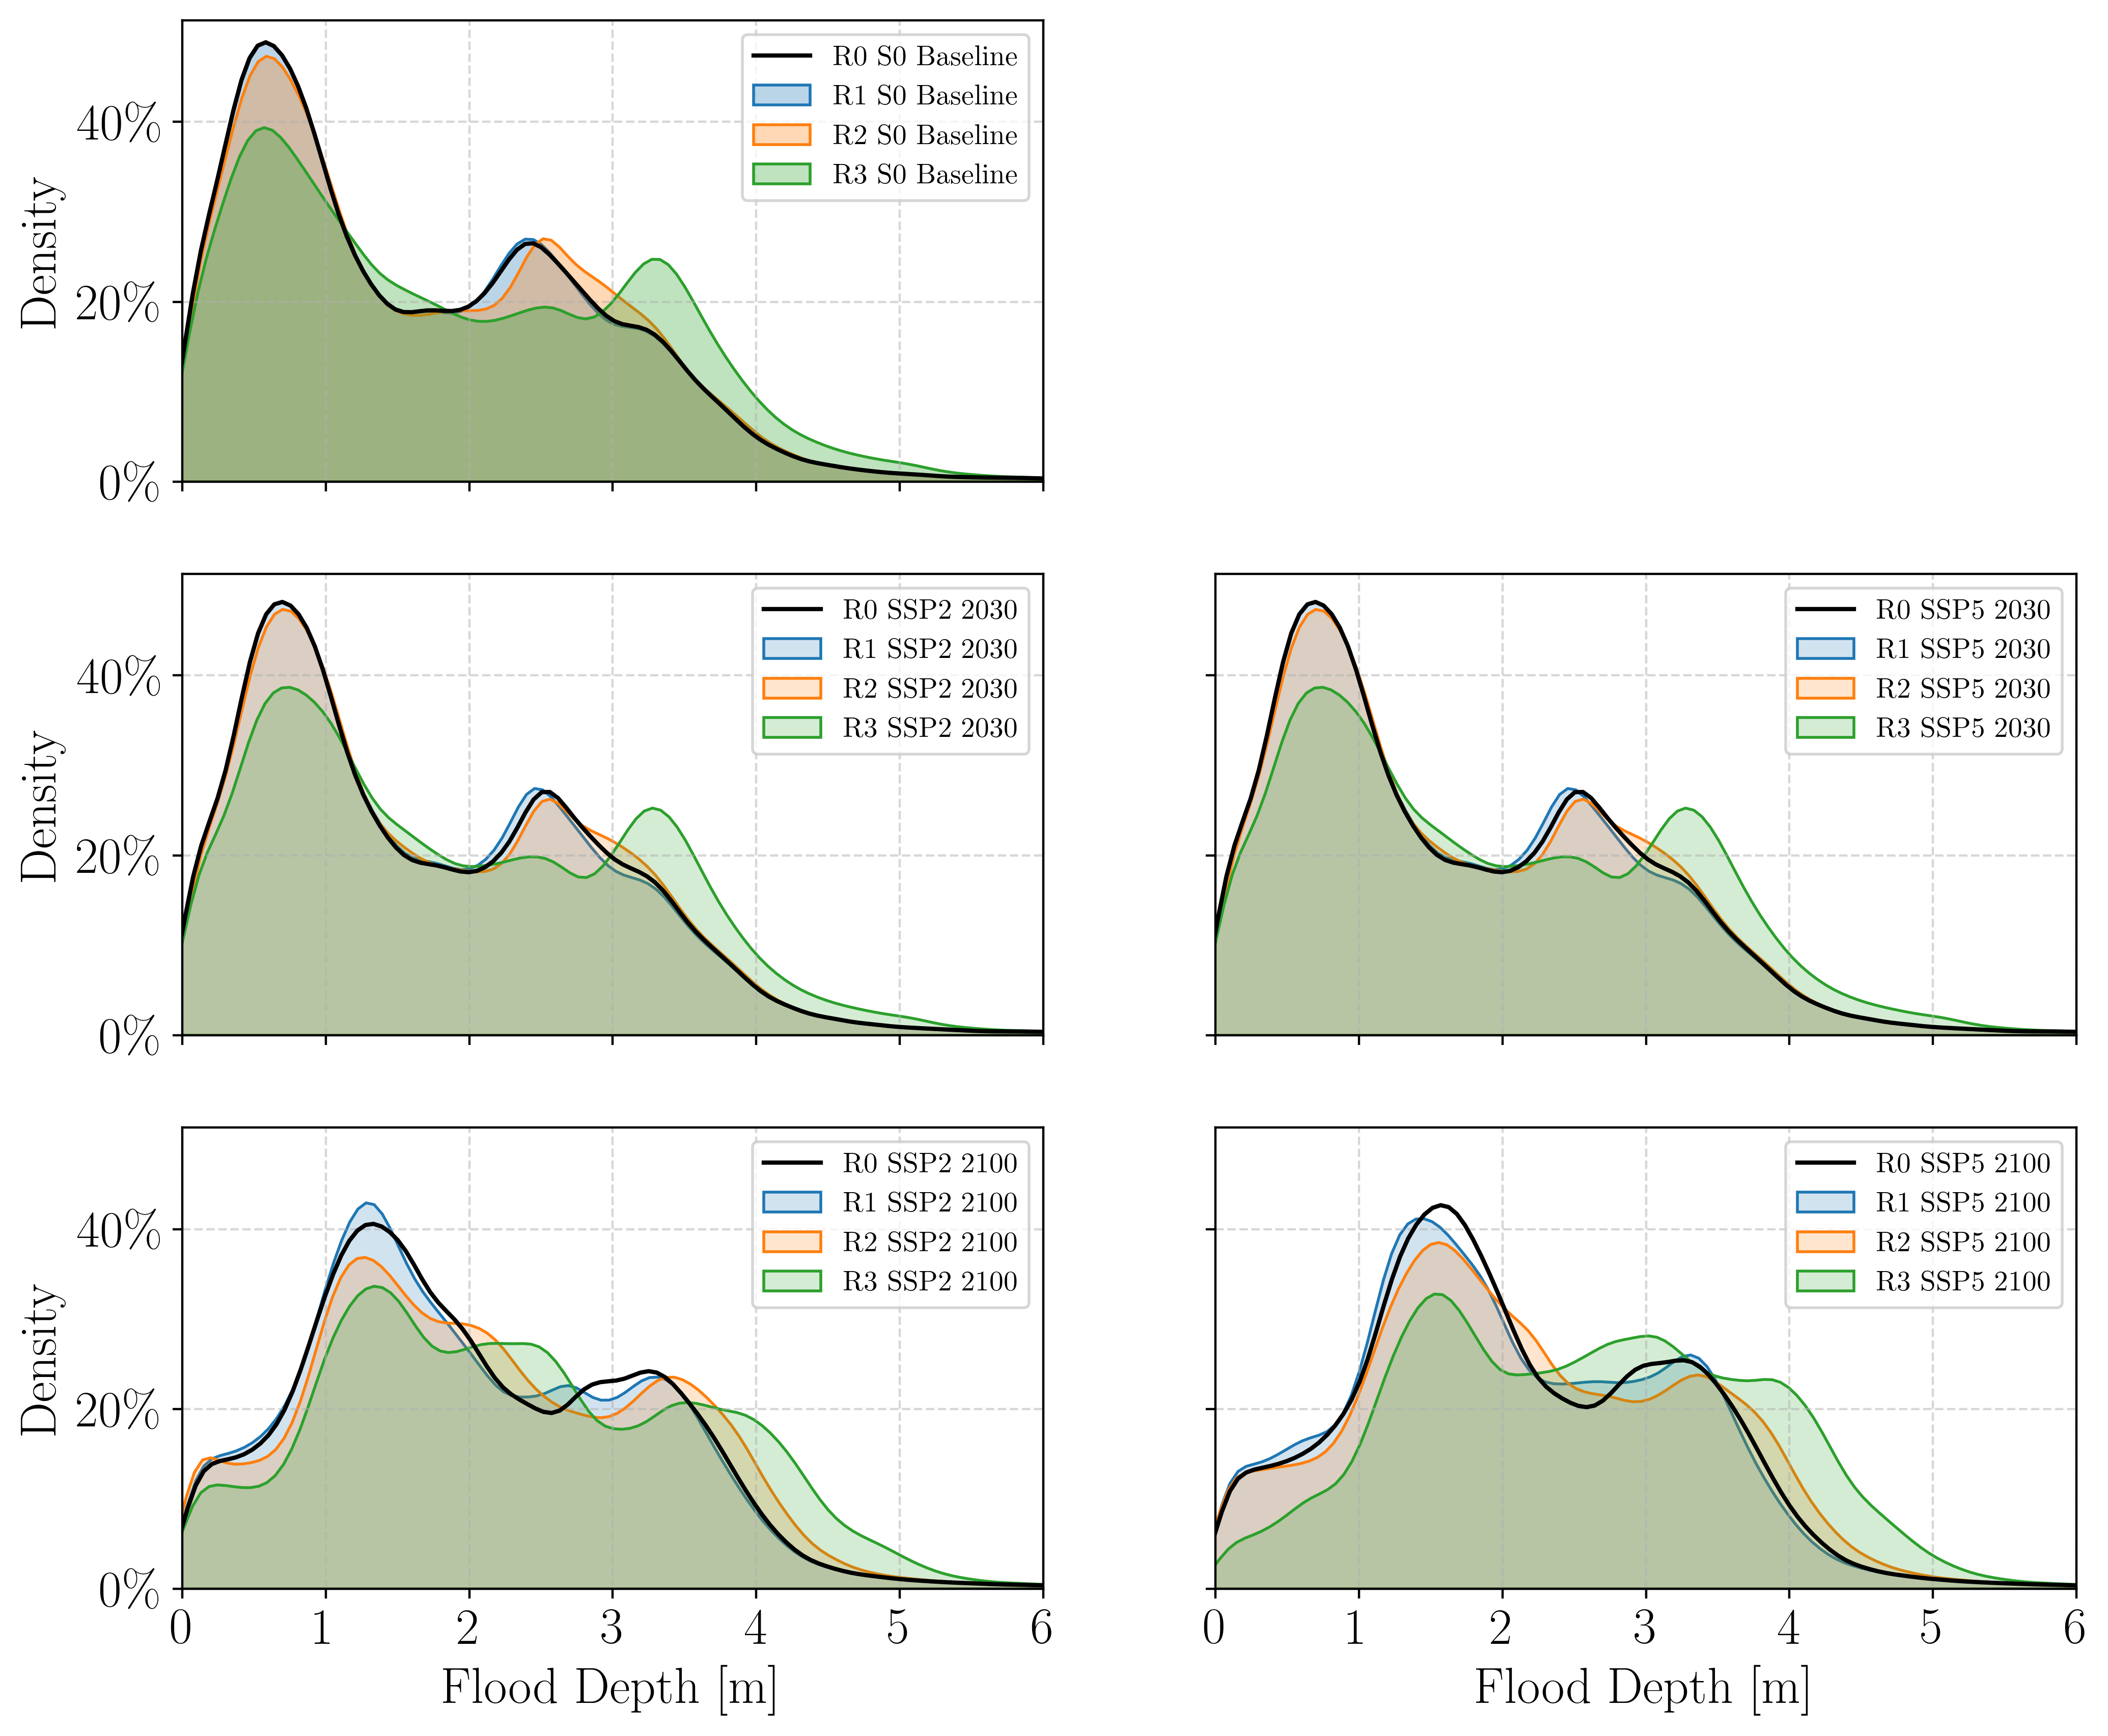

In [28]:
import seaborn as sns
    
def get_valid_values(path):
    arr = rxr.open_rasterio(path)
    arr = arr.where(arr != arr.attrs['_FillValue'], np.nan)
    return arr.values.flatten()[~np.isnan(arr.values.flatten())]

fig, axs = plt.subplots(3, 2, figsize=(12, 10), dpi=400, sharex=True, sharey=True)

paths_ssp2 = [
    (path_r1_ssp2_2030, "SSP2", "R1"),
    (path_r2_ssp2_2030, "SSP2", "R2"),
    (path_r3_ssp2_2030, "SSP2", "R3"),
    (path_r1_ssp2_2100, "SSP2", "R1"),
    (path_r2_ssp2_2100, "SSP2", "R2"),
    (path_r3_ssp2_2100, "SSP2", "R3")
]

paths_ssp5 = [
    (path_r1_ssp5_2030, "SSP5", "R1"),
    (path_r2_ssp5_2030, "SSP5", "R2"),
    (path_r3_ssp5_2030, "SSP5", "R3"),
    (path_r1_ssp5_2100, "SSP5", "R1"),
    (path_r2_ssp5_2100, "SSP5", "R2"),
    (path_r3_ssp5_2100, "SSP5", "R3")
]

data_r0_s0 = get_valid_values(path_r0_s0)
data_r0_ssp2_2030 = get_valid_values(path_r0_ssp2_2030)
data_r0_ssp2_2100 = get_valid_values(path_r0_ssp2_2100)
data_r0_ssp5_2030 = get_valid_values(path_r0_ssp5_2030)
data_r0_ssp5_2100 = get_valid_values(path_r0_ssp5_2100)
data_r1 = get_valid_values(path_r1_s0)
data_r2 = get_valid_values(path_r2_s0)
data_r3 = get_valid_values(path_r3_s0)

for col in range(1):
    sns.kdeplot(data_r0_s0, ax=axs[0, col], label='R0 S0 Baseline', alpha=1, zorder=10, color='k')
    sns.kdeplot(data_r1, ax=axs[0, col], label='R1 S0 Baseline', fill=True, alpha=0.3)
    sns.kdeplot(data_r2, ax=axs[0, col], label='R2 S0 Baseline', fill=True, alpha=0.3)
    sns.kdeplot(data_r3, ax=axs[0, col], label='R3 S0 Baseline', fill=True, alpha=0.3)
    axs[0, col].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
    axs[0, col].grid(True, linestyle='--', alpha=0.5)
    axs[0, col].set_xlim(0, 6)
    axs[0, col].xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6))
    axs[0, col].legend(fontsize=10)

# Display image in the top-right subplot
#img = plt.imread('/mnt/Work/mangrove-thesis/figures/mangrove_retreats.png')
#axs[0, 1].imshow(img)
axs[0, 1].axis('off')

sns.kdeplot(data_r0_ssp2_2030, ax=axs[1,0], label='R0 SSP2 2030', alpha=1, zorder=10, color='k')

sns.kdeplot(data_r0_ssp2_2100, ax=axs[2,0], label='R0 SSP2 2100', alpha=1, zorder=10, color='k')

sns.kdeplot(data_r0_ssp5_2030, ax=axs[1,1], label='R0 SSP5 2030', alpha=1, zorder=10, color='k')

sns.kdeplot(data_r0_ssp5_2100, ax=axs[2,1], label='R0 SSP5 2100', alpha=1, zorder=10, color='k')

# Helper to plot scenario KDEs
def plot_scenario_kdes(paths, ax, year):
    for path, scenario, retreat in paths:
        data = get_valid_values(path)
        sns.kdeplot(data, ax=ax, label=f'{retreat} {scenario} {year}',
                    fill=True, alpha=0.2)
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlim(0, 6)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6))
    ax.legend(fontsize=10)

# SSP2 2030 and 2100
plot_scenario_kdes(paths_ssp2[0:3], axs[1, 0], "2030")
plot_scenario_kdes(paths_ssp2[3:], axs[2, 0], "2100")

# SSP5 2030 and 2100
plot_scenario_kdes(paths_ssp5[0:3], axs[1, 1], "2030")
plot_scenario_kdes(paths_ssp5[3:], axs[2, 1], "2100")

axs[-1, 0].set_xlabel('Flood Depth [m]')
axs[-1, 1].set_xlabel('Flood Depth [m]')

plt.rcParams.update({
    'font.size': 18,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    "text.usetex": True,
    })

plt.show()

#### S0 - No SLR

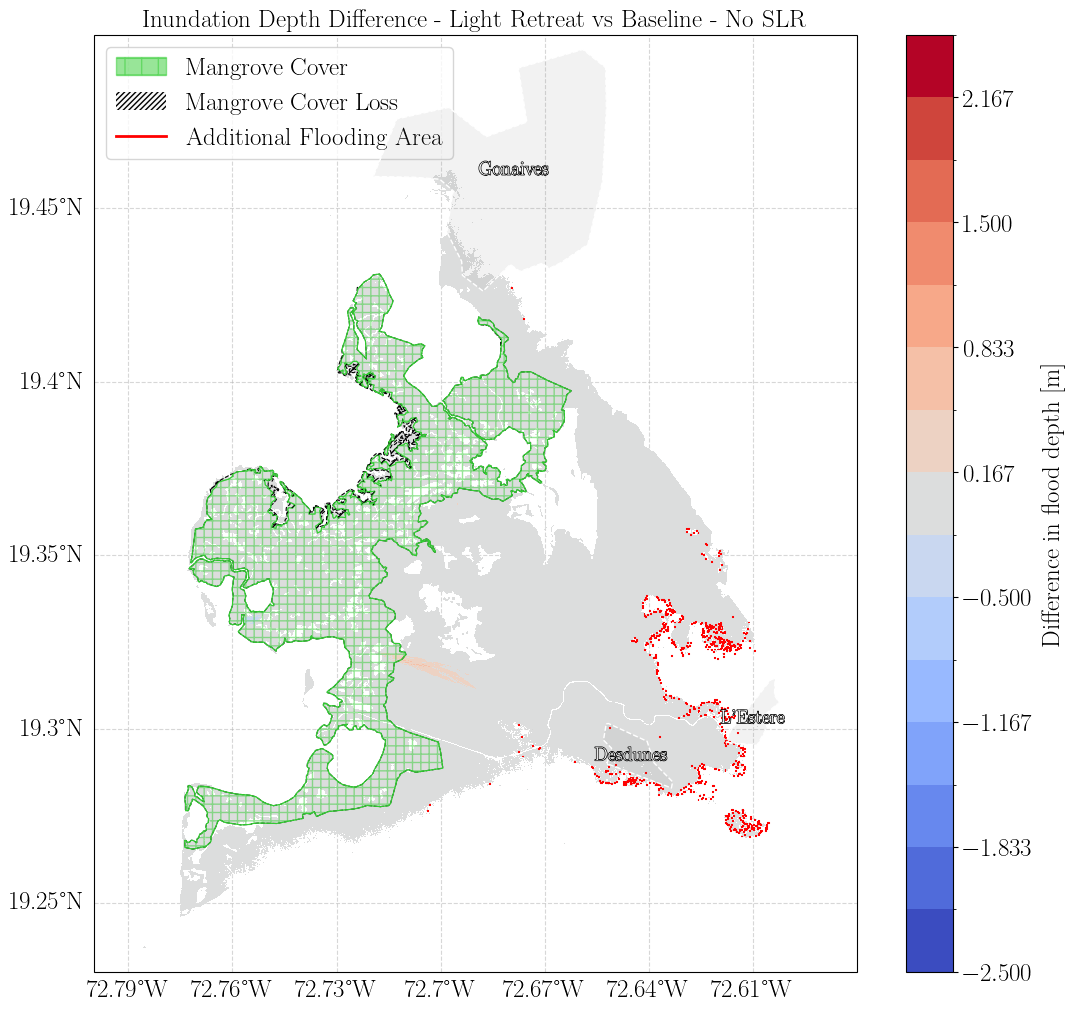

In [74]:
# R0 
title_scene = 'S0'
title = f'Inundation Depth Difference - Light Retreat vs Baseline - No SLR'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r1']['geometry']])

diff_test = plot_inter_extents(path_r0_s0, path_r1_s0, cover_base, cover, title_scene, title)

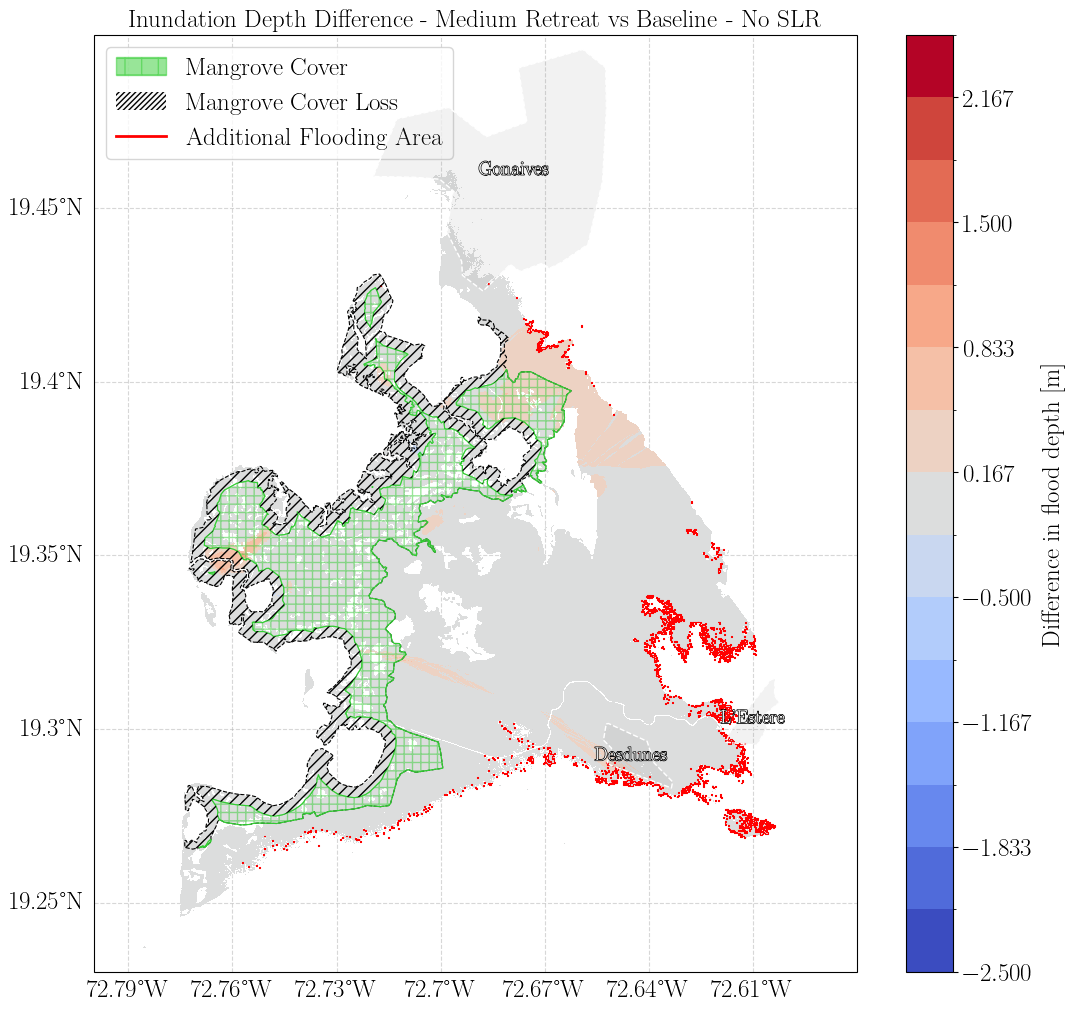

In [75]:
# R0 
title_scene = 'S0'
title = f'Inundation Depth Difference - Medium Retreat vs Baseline - No SLR'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r2']['geometry']])

diff_test = plot_inter_extents(path_r0_s0, path_r2_s0, cover_base, cover, title_scene, title)

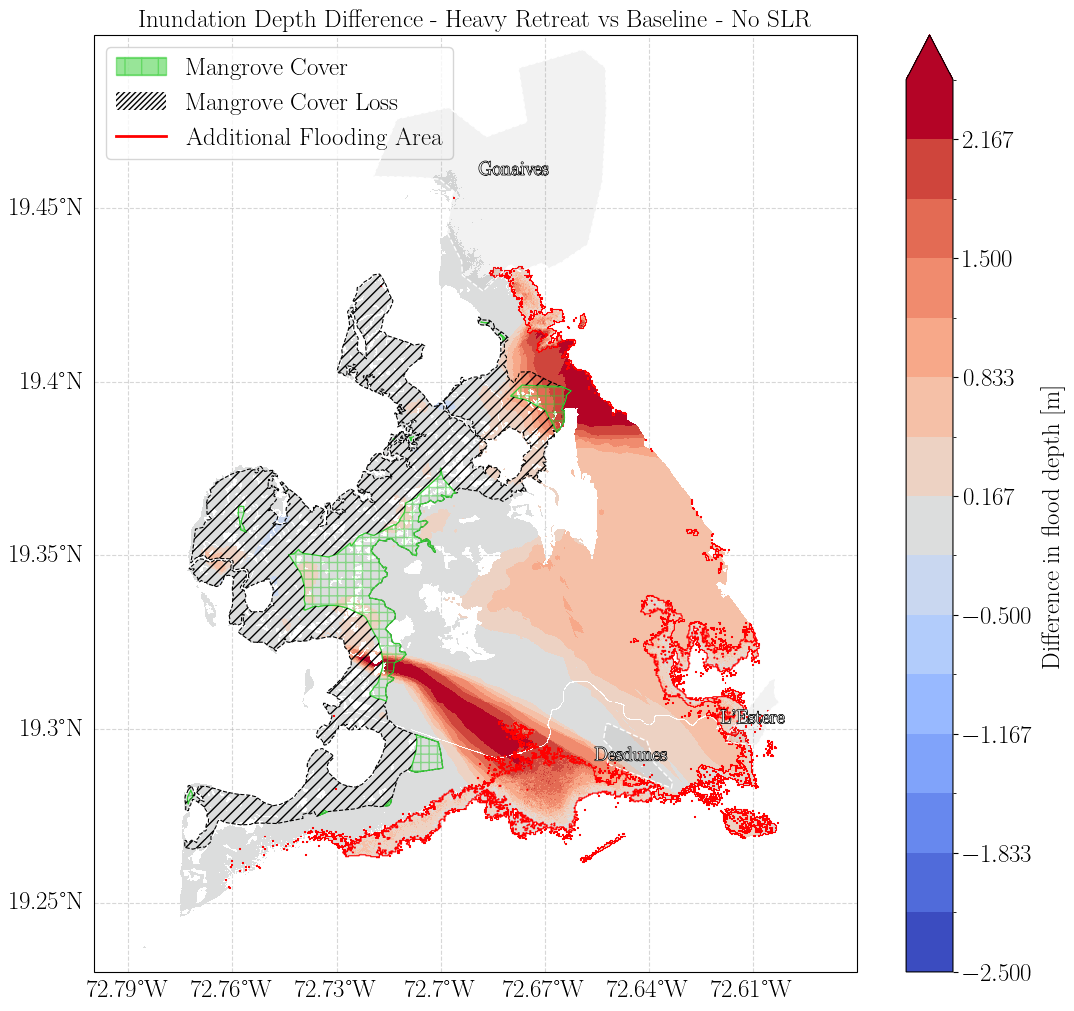

In [76]:
# R0 
title_scene = 'S0'
title = f'Inundation Depth Difference - Heavy Retreat vs Baseline - No SLR'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r3']['geometry']])

diff_test = plot_inter_extents(path_r0_s0, path_r3_s0, cover_base, cover, title_scene, title)

#### SSP2-2100

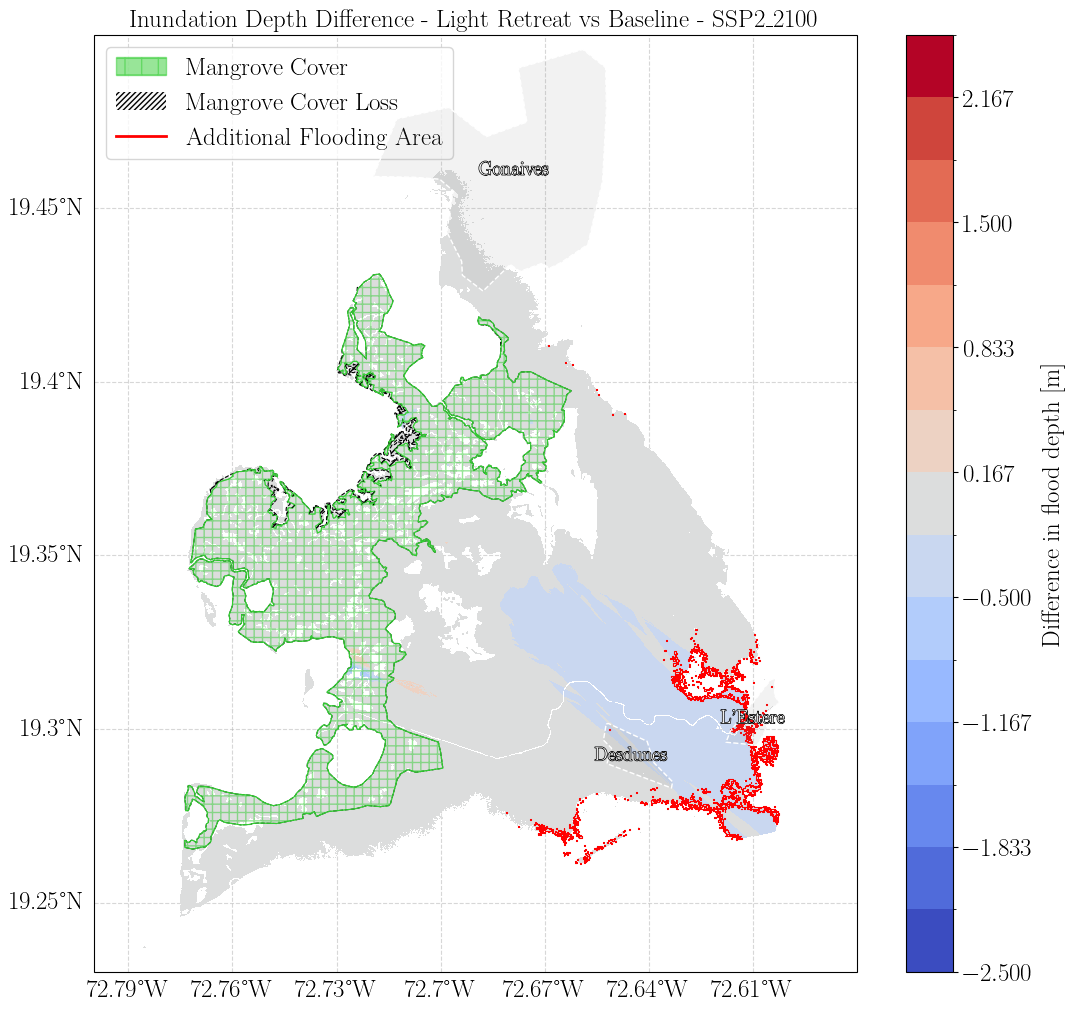

In [77]:
# R0 
title_scene = 'SSP2_2100'
title = f'Inundation Depth Difference - Light Retreat vs Baseline - {title_scene}'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r1']['geometry']])

diff_test = plot_inter_extents(path_r0_ssp2_2100, path_r1_ssp2_2100, cover_base, cover, title_scene, title)

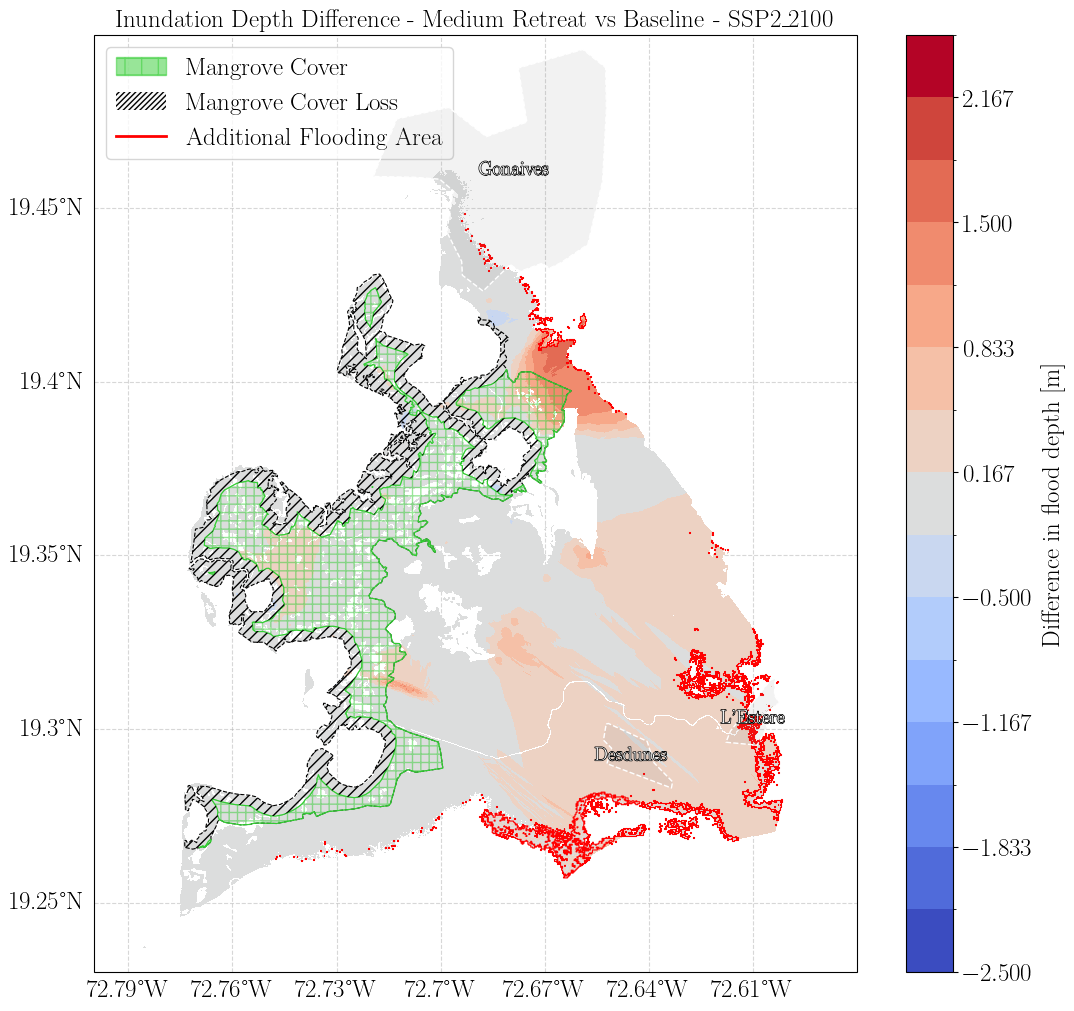

In [78]:
# R0 
title_scene = 'SSP2_2100'
title = f'Inundation Depth Difference - Medium Retreat vs Baseline - {title_scene}'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r2']['geometry']])

diff_test = plot_inter_extents(path_r0_ssp2_2100, path_r2_ssp2_2100, cover_base, cover, title_scene, title)

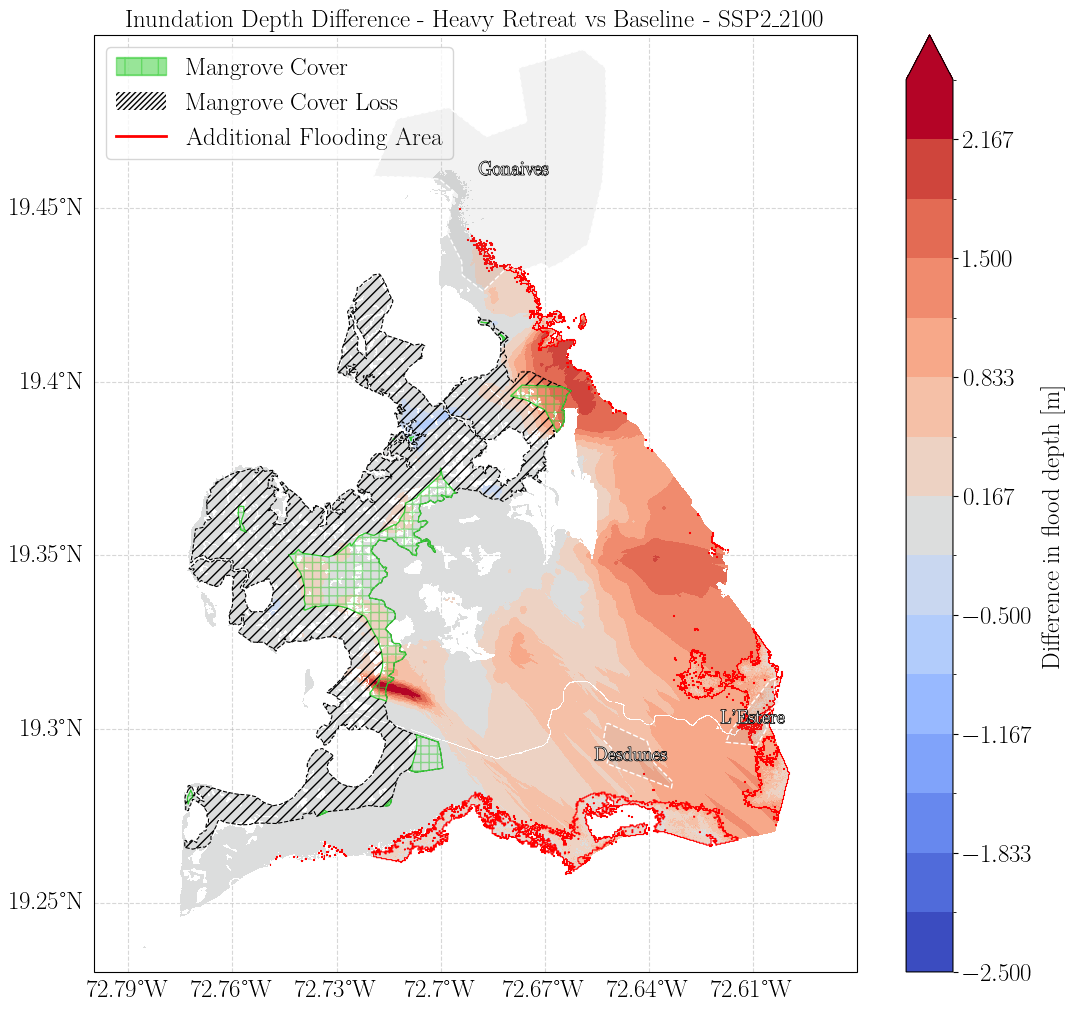

In [79]:
# R0 
title_scene = 'SSP2_2100'
title = f'Inundation Depth Difference - Heavy Retreat vs Baseline - {title_scene}'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r3']['geometry']])

diff_test = plot_inter_extents(path_r0_ssp2_2100, path_r3_ssp2_2100, cover_base, cover, title_scene, title)

#### SSP5-2100

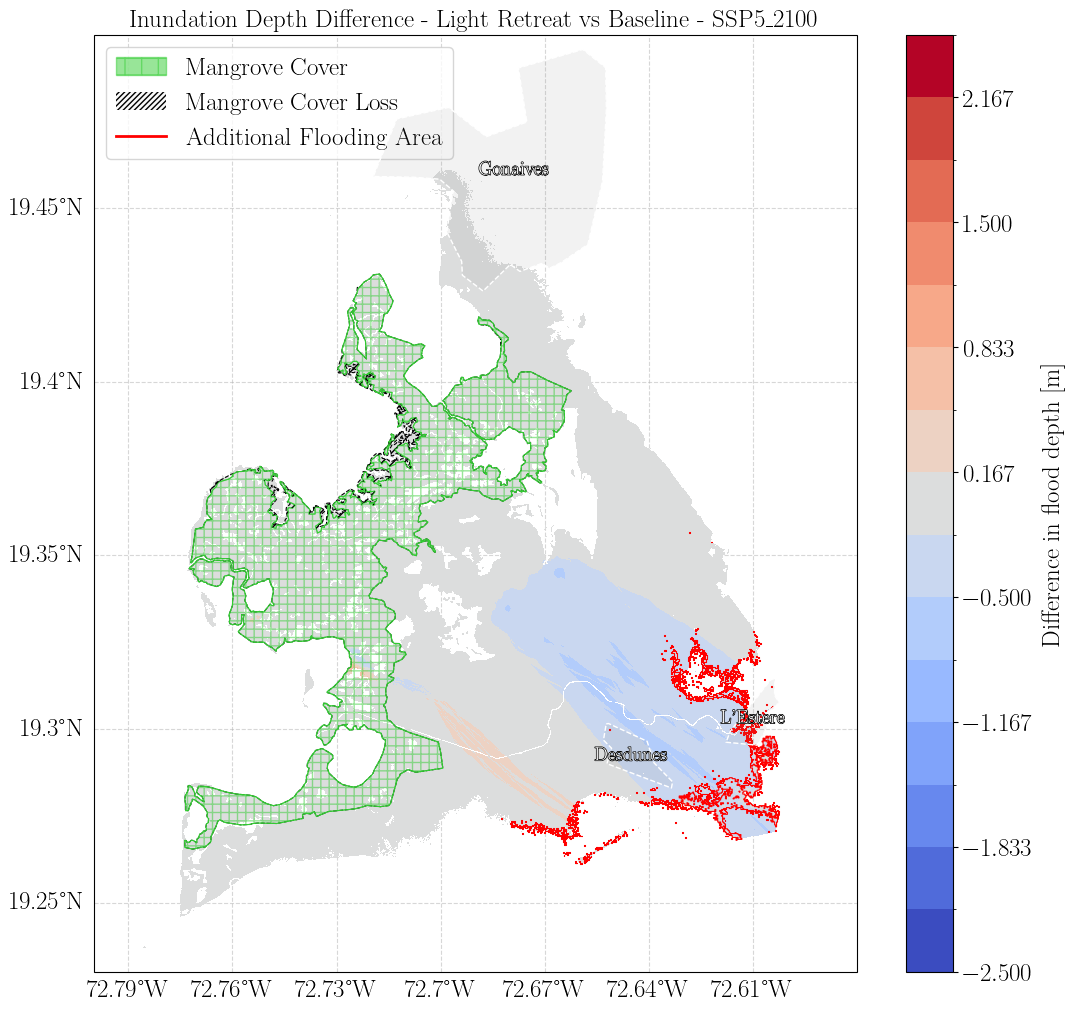

In [80]:
# R0 
title_scene = 'SSP5_2100'
title = f'Inundation Depth Difference - Light Retreat vs Baseline - {title_scene}'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r1']['geometry']])

diff_test = plot_inter_extents(path_r0_ssp5_2100, path_r1_ssp5_2100, cover_base, cover, title_scene, title)

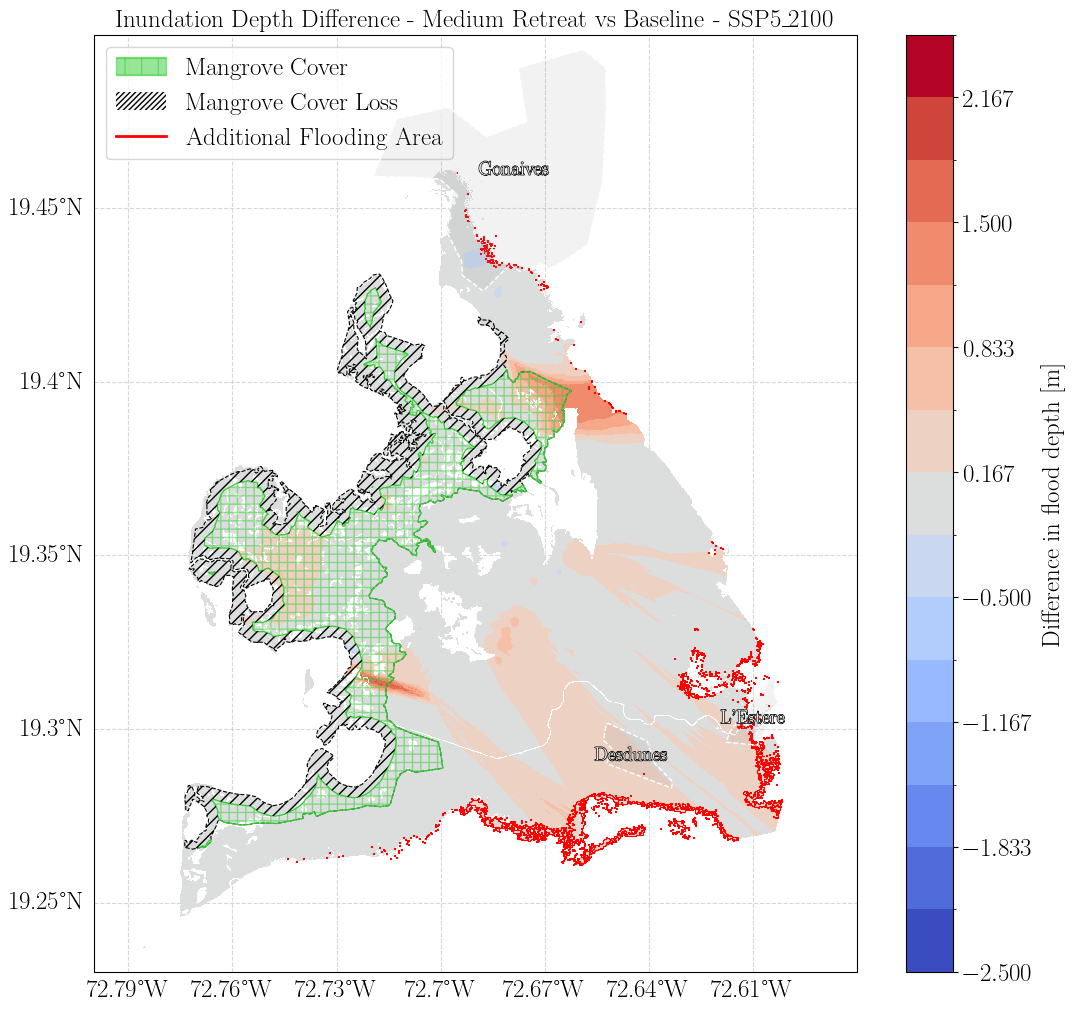

In [81]:
title_scene = 'SSP5_2100'
title = f'Inundation Depth Difference - Medium Retreat vs Baseline - {title_scene}'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r2']['geometry']])

diff_test = plot_inter_extents(path_r0_ssp5_2100, path_r2_ssp5_2100, cover_base, cover, title_scene, title)

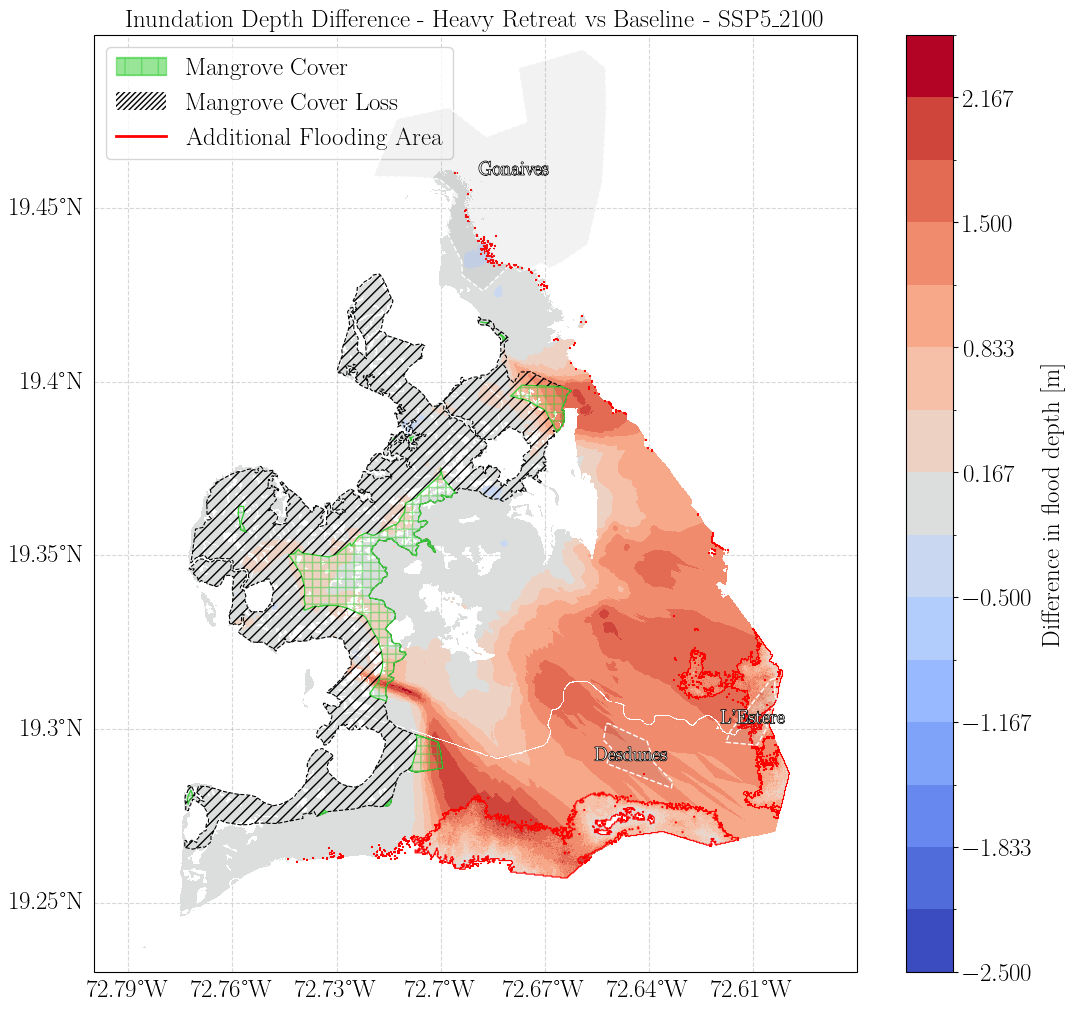

In [82]:
title_scene = 'SSP5_2100'
title = f'Inundation Depth Difference - Heavy Retreat vs Baseline - {title_scene}'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r3']['geometry']])

diff_test = plot_inter_extents(path_r0_ssp5_2100, path_r3_ssp5_2100, cover_base, cover, title_scene, title)